# Projekt: Bild-Klassifikator für eigene Objekte

In [38]:
# Import Libraries
# import libraries
# from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image # Keras own inbuild image class
from tensorflow.keras.layers import Dense,Dropout,GlobalAveragePooling2D,Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import Sequential,Input,Model

import numpy as np
import matplotlib.pyplot as plt

## Phase 1: Datensammlung

Es wurden Bilder der Klassen Bottle, Cup, Keyboard und Pen gesammelt.
Im ersten Schritt wurden die Bilder mithilfe des [Normalize Notebook](normalize.ipynb) normalisiert, um ihre Größe lokal zu reduzieren und sie anschließend effizient auf GitHub hochzuladen.

## Phase 2: Datenverarbeitung & Exploration

- Bottle
- Cup
- Keyboard
- Pen

### Lade die Bilder und verschaffe dir einen Überblick:

In [39]:
img = image.load_img('dataset/train/bottle/IMG_2646.jpg')
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [40]:
#convert image to array, can also specify datatype
img = image.img_to_array(img,dtype='uint8')

In [41]:
img.shape

(224, 224, 3)

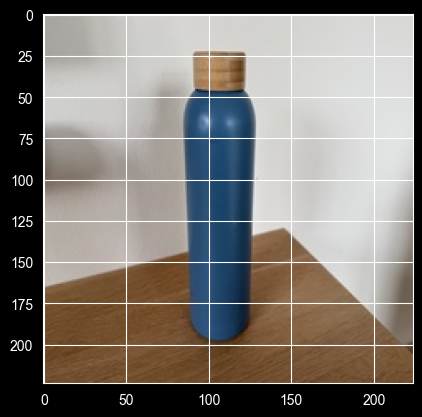

In [42]:
#plot image 
plt.imshow(img)

### Loading the entire images and labels

In [43]:
# Let's explore the data folder
import os
base_path = 'dataset/train/'

# Let's define the classes
classes = os.listdir(base_path)

In [44]:
 for class_ in classes:
        print(class_)

cup
pen
bottle
keyboard


In [45]:
def load_image(base_path):
    """it loads all the image into X and the classes in y """
    X_list = []
    y_list = []
    classes = os.listdir(base_path)
    for class_ in classes:
        if class_!='.DS_Store':
        
            files = os.listdir(base_path+class_)
            for file in files:
                pic = image.load_img(path=base_path+class_+'/'+f'{file}',target_size=(224,224))
                numpy_image = np.array(pic)
                processed_image = preprocess_input(numpy_image)
                X_list.append(processed_image)
                y_list.append(class_)

    X = np.array(X_list)
    y = np.array(y_list)
    
    return X, y, classes

In [46]:
X, y, classes= load_image(base_path)

In [47]:
X.shape

(280, 224, 224, 3)

In [48]:
y

array(['cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup',
       'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup',
       'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup',
       'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup',
       'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup',
       'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup',
       'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup',
       'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'pen', 'pen',
       'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen',
       'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen',
       'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen',
       'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen',
       'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen',
       'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen',
       'pen', 'pen',

## Implementiere Preprocessing:

In [49]:
X = preprocess_input(X)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


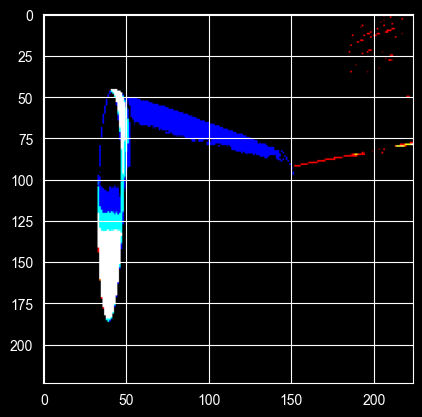

In [50]:
plt.imshow(X[0])

## Richte Data Augmentation ein:

In [51]:
# define an image data generator
# Data augmentation: Applies random distortions and transformations to the images (only on your training data!).

data_gen = image.ImageDataGenerator(
    # define the preprocessing function that should be applied to all images
    preprocessing_function=preprocess_input,
    # fill_mode='nearest',
    rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=(1.1, 1.2),
    # shear_range=0.2
)

In [52]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory='dataset/train',
        class_mode="categorical",
        #classes=classes,
        batch_size=32,
        target_size=(224, 224),
)

Found 280 images belonging to 4 classes.


In [53]:
train_data_gen.class_indices

{'cup': 0, 'pen': 1, 'bottle': 2, 'keyboard': 3}

In [54]:
train_data_gen.samples

280

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


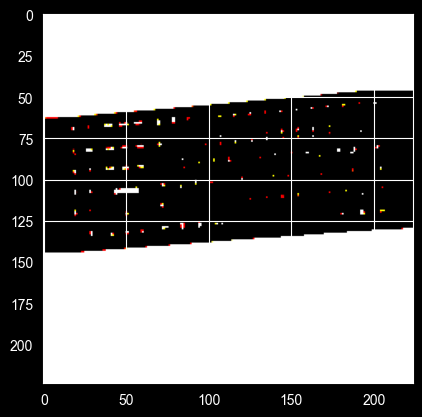

In [55]:
batch_bilder, batch_labels = train_data_gen[0]

image_to_show = batch_bilder[0]

plt.imshow(image_to_show)

In [56]:
val_data_gen = data_gen.flow_from_directory(
         directory='dataset/val/',
         class_mode="categorical",
         classes=classes,
         batch_size=150,
         target_size=(224, 224),
)

Found 60 images belonging to 4 classes.


## Phase 3: Modelltraining mit Transfer Learning

In [57]:
import tensorflow.keras.backend as K
K.clear_session()

#1. Select the convolutional base / Pretrained network
base_model = ResNet50(include_top=False)

In [58]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [59]:
#2. Freeze the weights in order to not retrain the loaded pre-trained model
#base_model.trainable= False

In [60]:
train_data_gen.image_shape

(224, 224, 3)

In [61]:
val_data_gen.image_shape

(224, 224, 3)

In [62]:
base_model.trainable = False

inputs = Input(shape=(224,224,3))
base = base_model(inputs)

# dont forget to flatten out before the final layer
flatten = Flatten()(base)

outputs = Dense(4,activation='softmax')(flatten)

model_tf = Model(inputs,outputs)

In [63]:
model_tf.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 4)                 401412    
                                                                 
Total params: 23989124 (91.51 MB)
Trainable params: 401412 (1.53 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [64]:

# 3. Kompilieren (Wir kompilieren jetzt 'model', NICHT 'base_model')
model_tf.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 4. Trainieren (Wir trainieren 'model')
history = model_tf.fit(train_data_gen,
                    verbose=2,
                    epochs=10,
                    validation_data=val_data_gen)

Epoch 1/10
1/1 - 6s - loss: 2.2913 - accuracy: 0.2929 - val_loss: 1.7223 - val_accuracy: 0.7000 - 6s/epoch - 6s/step
Epoch 2/10
1/1 - 4s - loss: 2.0461 - accuracy: 0.7429 - val_loss: 6.8354e-06 - val_accuracy: 1.0000 - 4s/epoch - 4s/step
Epoch 3/10
1/1 - 4s - loss: 0.0518 - accuracy: 0.9857 - val_loss: 0.2338 - val_accuracy: 0.9833 - 4s/epoch - 4s/step
Epoch 4/10
1/1 - 4s - loss: 0.2237 - accuracy: 0.9821 - val_loss: 0.3381 - val_accuracy: 0.9667 - 4s/epoch - 4s/step
Epoch 5/10
1/1 - 4s - loss: 0.3749 - accuracy: 0.9750 - val_loss: 0.0601 - val_accuracy: 0.9833 - 4s/epoch - 4s/step
Epoch 6/10
1/1 - 4s - loss: 0.3647 - accuracy: 0.9607 - val_loss: 1.4304e-04 - val_accuracy: 1.0000 - 4s/epoch - 4s/step
Epoch 7/10
1/1 - 5s - loss: 0.1791 - accuracy: 0.9714 - val_loss: 3.3776e-08 - val_accuracy: 1.0000 - 5s/epoch - 5s/step
Epoch 8/10
1/1 - 4s - loss: 0.1596 - accuracy: 0.9786 - val_loss: 0.0748 - val_accuracy: 0.9833 - 4s/epoch - 4s/step
Epoch 9/10
1/1 - 4s - loss: 0.0380 - accuracy: 0.996

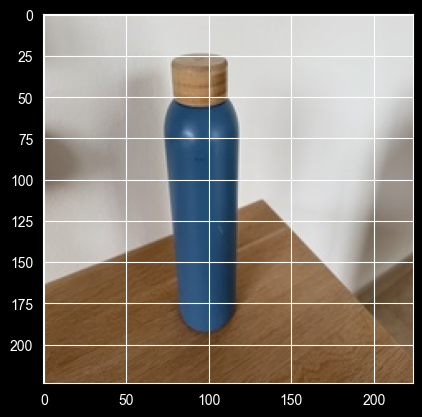

In [65]:

img = image.load_img('dataset/test/bottle/IMG_2647.jpg',target_size=(224,224))
img = image.img_to_array(img,dtype='uint8')
plt.imshow(img)

In [66]:
img_p = preprocess_input(img)
x=np.expand_dims(img_p,axis=0)
print(x.shape)

(1, 224, 224, 3)


In [67]:
model_tf.predict(x)

1/1 [==============================] - 0s 270ms/step


array([[6.4836347e-31, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00]],
      dtype=float32)

In [68]:
classes

['cup', 'pen', 'bottle', 'keyboard']

In [69]:
# Let's explore the data folder
test_path = 'dataset/test/'

# Let's define the classes
classes_test = os.listdir(test_path)
X_test, y_test, classes_test= load_image(test_path)

In [70]:
shuffle=False

In [71]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Test-Daten Generator erstellen
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    directory='dataset/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 61 images belonging to 4 classes.


In [72]:
# Berechnet Loss und Accuracy
loss, accuracy = model_tf.evaluate(test_generator)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

2/2 [==============================] - 1s 331ms/step - loss: 112.2560 - accuracy: 0.0328
Test Loss: 112.2560
Test Accuracy: 3.28%


Mache Vorhersagen...
2/2 [==============================] - 1s 304ms/step

--- Detaillierter Report ---
              precision    recall  f1-score   support

      bottle       0.12      0.13      0.12        15
         cup       0.00      0.00      0.00        15
    keyboard       0.00      0.00      0.00        16
         pen       0.00      0.00      0.00        15

    accuracy                           0.03        61
   macro avg       0.03      0.03      0.03        61
weighted avg       0.03      0.03      0.03        61



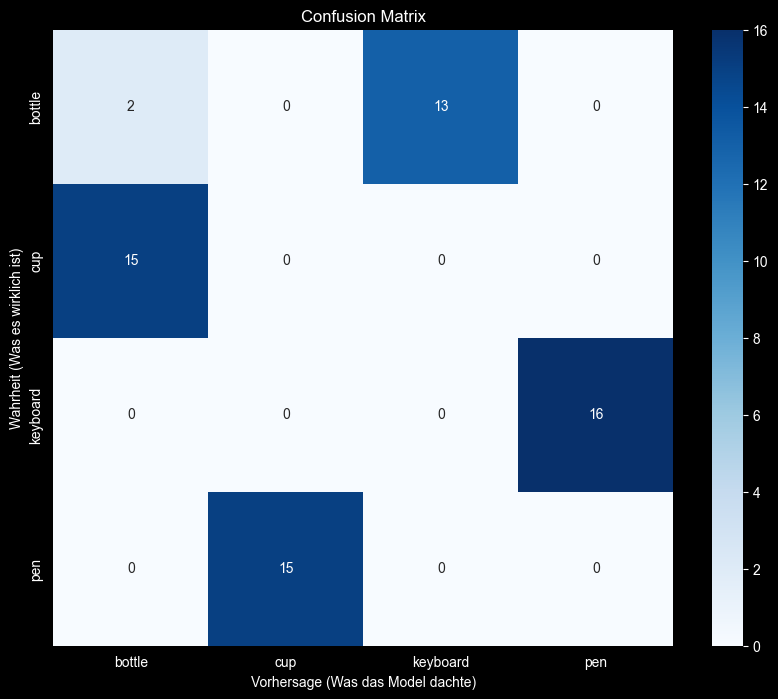

In [73]:
# 1. Vorhersagen für alle Bilder machen
print("Mache Vorhersagen...")
predictions = model_tf.predict(test_generator)

# 2. Die Wahrscheinlichkeiten in Klassen-Indices umwandeln (argmax)
# Aus [0.1, 0.8, 0.1] wird Index 1
predicted_classes = np.argmax(predictions, axis=1)

# 3. Die ECHTEN Klassen holen
true_classes = test_generator.classes

# 4. Die Namen der Klassen holen
class_labels = list(test_generator.class_indices.keys())

# --- REPORT ---
print("\n--- Detaillierter Report ---")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# --- CONFUSION MATRIX (Visuell) ---
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Vorhersage (Was das Model dachte)')
plt.ylabel('Wahrheit (Was es wirklich ist)')
plt.title('Confusion Matrix')
plt.show()

# Wähle ein vortrainiertes Modell als Basis:

In [ ]:
classes

## Phase 4: Evaluation

## Phase 5: Testing mit neuen Bildern

## KI Anpassung

In [74]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Sicherstellen, dass alte Sessions gelöscht sind
tf.keras.backend.clear_session()

print(f"TensorFlow Version: {tf.__version__}")
print("Setup abgeschlossen.")

TensorFlow Version: 2.15.0
Setup abgeschlossen.


In [75]:
# --- KONFIGURATION ---
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
TRAIN_DIR = 'dataset/train'
VAL_DIR = 'dataset/val'
TEST_DIR = 'dataset/test'

# 1. Generator für TRAINING (Mit Augmentation/Verzerrung)
# Das hilft dem Modell, robust zu werden (drehen, zoomen, spiegeln).
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # WICHTIG für ResNet!
    rotation_range=20,      # Drehen
    width_shift_range=0.2,  # Verschieben
    height_shift_range=0.2,
    horizontal_flip=True,   # Spiegeln
    zoom_range=0.2          # Zoomen
)

# 2. Generator für VALIDATION & TEST (Nur Preprocessing)
# Hier dürfen wir NICHT verzerren, wir wollen echte Daten testen.
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

print("--- Lade Trainingsdaten ---")
train_generator = train_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True # WICHTIG: Mischen!
)

print("\n--- Lade Validierungsdaten ---")
val_generator = val_test_datagen.flow_from_directory(
    directory=VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Nicht mischen, damit wir Ergebnisse vergleichen können
)

print("\n--- Lade Testdaten ---")
test_generator = val_test_datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # WICHTIG: Nicht mischen für Confusion Matrix!
)

# Klassen-Namen speichern
class_names = list(train_generator.class_indices.keys())
print(f"\nErkannte Klassen: {class_names}")

--- Lade Trainingsdaten ---
Found 280 images belonging to 4 classes.

--- Lade Validierungsdaten ---
Found 60 images belonging to 4 classes.

--- Lade Testdaten ---
Found 61 images belonging to 4 classes.

Erkannte Klassen: ['bottle', 'cup', 'keyboard', 'pen']


In [76]:
# 1. Basis-Modell laden (ohne den Klassifizierungs-Teil "Top")
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 2. Basis einfrieren (damit wir die vortrainierten Filter nicht zerstören)
base_model.trainable = False

# 3. Neues Modell zusammenbauen
model = Sequential()

# A: ResNet als Basis
model.add(base_model)

# B: Pooling (Macht aus 7x7x2048 -> 1x2048 Vektor)
model.add(GlobalAveragePooling2D())

# C: Dropout (Verhindert Overfitting)
model.add(Dropout(0.5))

# D: Output Layer (Softmax für Wahrscheinlichkeiten)
# Wir holen die Anzahl der Klassen dynamisch aus dem Generator
num_classes = train_generator.num_classes
model.add(Dense(num_classes, activation='softmax'))

# 4. Modell Zusammenfassung
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 23595908 (90.01 MB)
Trainable params: 8196 (32.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [77]:
# Kompilieren
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training starten
# Wir speichern das Ergebnis in 'history' für den Plot später
history = model.fit(
    train_generator,
    epochs=10,  # Empfehlung: Mindestens 10 Epochen
    validation_data=val_generator,
    verbose=1
)

# Modell speichern
model.save('mein_resnet_final.keras')
print("Modell gespeichert.")

Epoch 1/10
9/9 [==============================] - 5s 440ms/step - loss: 1.3072 - accuracy: 0.4679 - val_loss: 0.3686 - val_accuracy: 0.9333
Epoch 2/10
9/9 [==============================] - 4s 391ms/step - loss: 0.3620 - accuracy: 0.8786 - val_loss: 0.1189 - val_accuracy: 1.0000
Epoch 3/10
9/9 [==============================] - 4s 406ms/step - loss: 0.1846 - accuracy: 0.9464 - val_loss: 0.0559 - val_accuracy: 1.0000
Epoch 4/10
9/9 [==============================] - 4s 396ms/step - loss: 0.1017 - accuracy: 0.9714 - val_loss: 0.0334 - val_accuracy: 1.0000
Epoch 5/10
9/9 [==============================] - 4s 419ms/step - loss: 0.1107 - accuracy: 0.9607 - val_loss: 0.0238 - val_accuracy: 1.0000
Epoch 6/10
9/9 [==============================] - 4s 415ms/step - loss: 0.0517 - accuracy: 0.9929 - val_loss: 0.0253 - val_accuracy: 1.0000
Epoch 7/10
9/9 [==============================] - 4s 443ms/step - loss: 0.0759 - accuracy: 0.9750 - val_loss: 0.0162 - val_accuracy: 1.0000
Epoch 8/10
9/9 [====

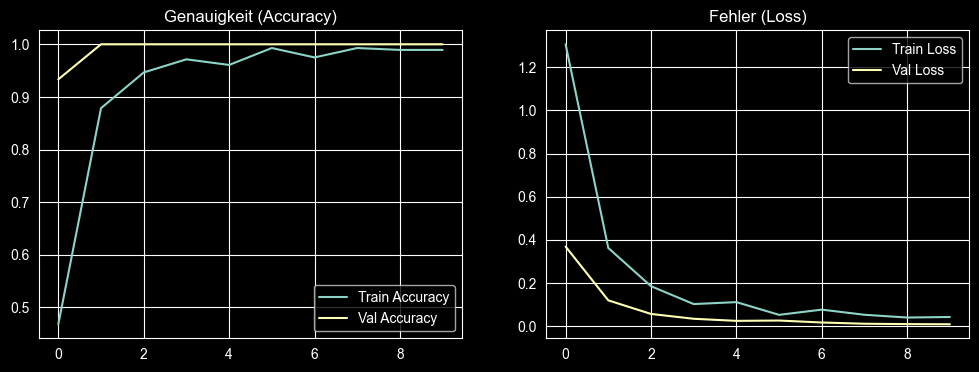


--- Starte finale Evaluation auf Test-Set ---
2/2 [==============================] - 1s 300ms/step - loss: 0.0660 - accuracy: 0.9672
Test Accuracy: 96.72%


2/2 [==============================] - 1s 306ms/step


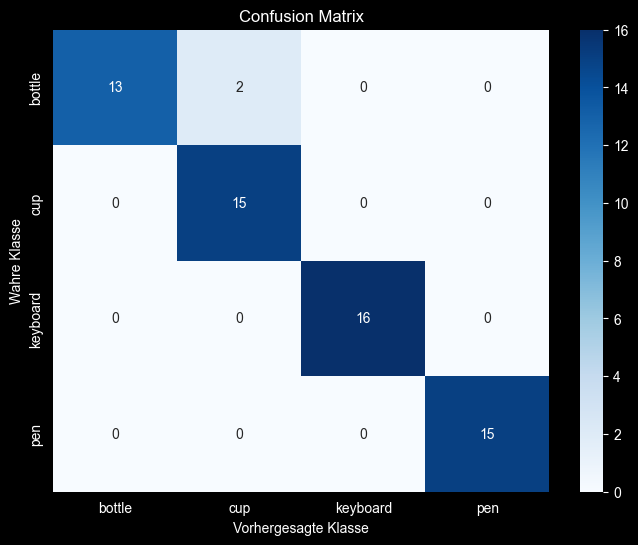

              precision    recall  f1-score   support

      bottle       1.00      0.87      0.93        15
         cup       0.88      1.00      0.94        15
    keyboard       1.00      1.00      1.00        16
         pen       1.00      1.00      1.00        15

    accuracy                           0.97        61
   macro avg       0.97      0.97      0.97        61
weighted avg       0.97      0.97      0.97        61



In [78]:
# 1. Trainings-Verlauf plotten
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Genauigkeit (Accuracy)')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Fehler (Loss)')
plt.legend()
plt.show()

# 2. Testen auf den Test-Daten
print("\n--- Starte finale Evaluation auf Test-Set ---")
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# 3. Confusion Matrix erstellen
# Vorhersagen machen
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Matrix zeichnen
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('Wahre Klasse')
plt.xlabel('Vorhergesagte Klasse')
plt.title('Confusion Matrix')
plt.show()

# Detaillierter Report
print(classification_report(true_classes, predicted_classes, target_names=class_names))

In [ ]:
# Speichert das komplette Modell (Architektur + Gewichte)
model_tf.save('mein_super_resnet.keras')
print("Modell erfolgreich gesichert!")